In [1]:
import sys
sys.path.insert(0, 'D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\Classes')

import warnings
warnings.filterwarnings('ignore')


from models import ClassificationModel, EmbeddingsModel, SiameseModel
from trainer import SiameseTrainerThreeClass, all_subjects, all_subjects_intense

import numpy as np
from tqdm import tqdm
import csv
import torch

### Siamese training

In [22]:
subjects_test = all_subjects[:1]
subjects_train = [sub for sub in all_subjects_intense if sub not in subjects_test]

In [30]:
trainer_hyperparameter = {
    "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\XITE\\normalized_subjects.pkl",
    "subjects_train": all_subjects,
    "subjects_test": subjects_test,
    "intense_dataset_train": False,
    "intense_dataset_test": False,
    "indices1_train": 3,
    "indices2_train": 1,
    "indices1_test": 1,
    "indices2_test": 0,
    "use_regression": False,
    "wandb": False,
    "log": True,
    "learning_rate": 0.001,
    "batch_size": 256,
    "batch_size_test": 256,
    "freeze_embed": False,
    "decision_function": 3,
    "filter": [-1,-2,-3],
    "weight_decay": 0,
    "lr_steps": 10,
    "number_steps": 200,
    "number_steps_testing": 10
}

model_embedding_hyperparameter = {
        "sigmoid": False,
        "dropout": 0.35,
        "layers": [207, 512, 64]
}

if trainer_hyperparameter["use_regression"]:
    head = 1
else:
    head = 2

model_classifier_hyperparameter = {
    "dropout": 0.35,
    "layers": [64, 32],
    "head_type": head
}


#
# head 1 for regression
# head 2 for classification
#

In [31]:
classifier_model = ClassificationModel(model_classifier_hyperparameter)
embedding_model = EmbeddingsModel(model_embedding_hyperparameter)

siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])

In [32]:
filter = lambda data: data["label"].isin(trainer_hyperparameter["filter"])
trainer = SiameseTrainerThreeClass(trainer_hyperparameter, siamese_model, device="cuda:0", filter=filter)

In [33]:
trainer.trainloop(20)

100%|██████████| 20/20 [37:00<00:00, 111.03s/it]

epoch: 1 | train_acc: 0.6403 | test_acc: 0.8202
epoch: 2 | train_acc: 0.6961 | test_acc: 0.8694
epoch: 3 | train_acc: 0.7157 | test_acc: 0.8975
epoch: 4 | train_acc: 0.7242 | test_acc: 0.8989
epoch: 5 | train_acc: 0.7356 | test_acc: 0.9045
epoch: 6 | train_acc: 0.7443 | test_acc: 0.9256
epoch: 7 | train_acc: 0.75 | test_acc: 0.9185
epoch: 8 | train_acc: 0.7539 | test_acc: 0.9087
epoch: 9 | train_acc: 0.7592 | test_acc: 0.8947
epoch: 10 | train_acc: 0.7632 | test_acc: 0.9073
epoch: 11 | train_acc: 0.7765 | test_acc: 0.8933
epoch: 12 | train_acc: 0.7838 | test_acc: 0.9059
epoch: 13 | train_acc: 0.7881 | test_acc: 0.9059
epoch: 14 | train_acc: 0.7918 | test_acc: 0.9382
epoch: 15 | train_acc: 0.7932 | test_acc: 0.9213
epoch: 16 | train_acc: 0.7975 | test_acc: 0.9185
epoch: 17 | train_acc: 0.7997 | test_acc: 0.9326
epoch: 18 | train_acc: 0.8025 | test_acc: 0.9087
epoch: 19 | train_acc: 0.8046 | test_acc: 0.9537
epoch: 20 | train_acc: 0.8073 | test_acc: 0.9368


In [34]:
torch.save(siamese_model.state_dict(), "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\ThreeClassSiamese\pretrained_models\model_phasic_electric.pth")

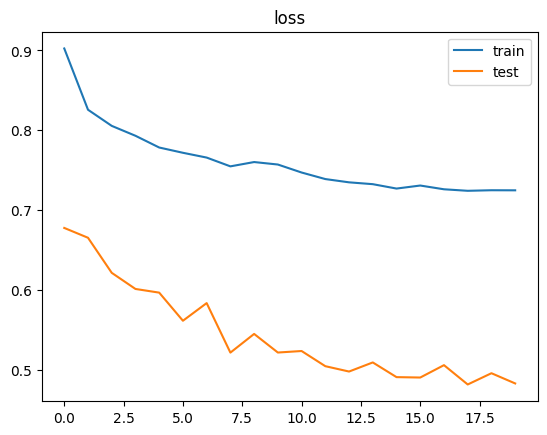

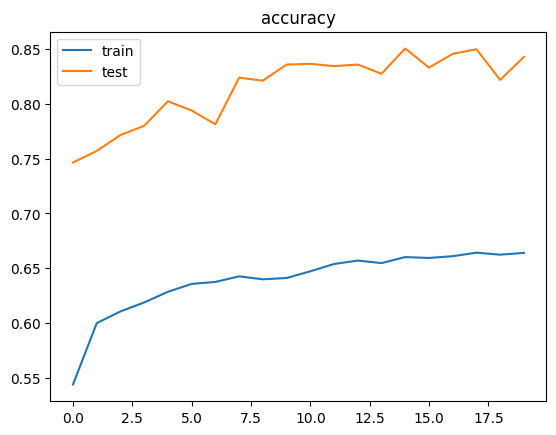

In [28]:
trainer.plot_history()

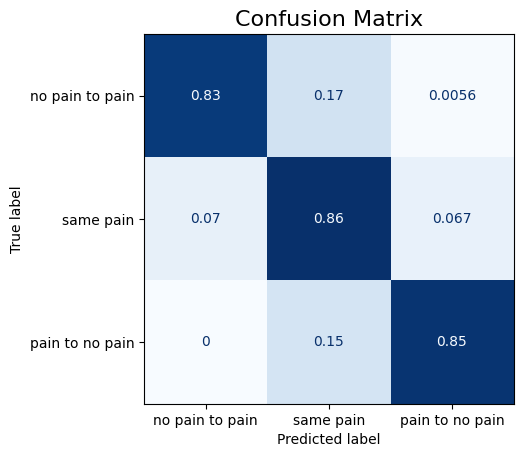

In [29]:
trainer.plot_cm()

### saving file

In [2]:
saving_path = "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\ThreeClassSiamese\\results\\xite_phasic.csv"

#with open(saving_path, mode='a') as result_file:
#    results_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#    results_writer.writerow(["subj", "accuracy", "cm", "best_epoch"])

### LOSO - INTENSE

In [36]:
for subj in tqdm(all_subjects_intense):
    subjects_test = [subj]
    subjects_train = [sub for sub in all_subjects_intense if sub not in subjects_test]

    trainer_hyperparameter = {
        "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\INTENSE2\\normalized_subjects.pkl",
        "subjects_train": subjects_train,
        "subjects_test": subjects_test,
        "intense_dataset_train": True,
        "intense_dataset_test": True,
        "indices1_train": 3,
        "indices2_train": 1,
        "indices1_test": 1,
        "indices2_test": 0,
        "use_regression": False,
        "wandb": False,
        "log": True,
        "learning_rate": 0.001,
        "batch_size": 256,
        "batch_size_test": 256,
        "freeze_embed": False,
        "decision_function": 3,
        "filter": [],
        "weight_decay": 0,
        "lr_steps": 10,
        "number_steps": 400,
        "number_steps_testing": 200
    }

    model_embedding_hyperparameter = {
            "sigmoid": False,
            "dropout": 0.35,
            "layers": [207, 512, 64]
    }

    if trainer_hyperparameter["use_regression"]:
        head = 1
    else:
        head=2

    model_classifier_hyperparameter = {
        "dropout": 0.35,
        "layers": [64, 32],
        "head_type": head
    }

    classifier_model = ClassificationModel(model_classifier_hyperparameter)
    embedding_model = EmbeddingsModel(model_embedding_hyperparameter)
    siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])
    
    _ = siamese_model.load_state_dict(torch.load("D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\ThreeClassSiamese\pretrained_models\model_all.pth"))
    
    trainer = SiameseTrainerThreeClass(trainer_hyperparameter, siamese_model, device="cuda:0")

    trainer.trainloop(20)

    best_epoch = max(trainer.history, key=lambda x:x['test_acc'])["epoch"]
    cm = trainer.history_cm[best_epoch-1]["cm"]

    acc = trainer.history[best_epoch-1]["test_acc"]

    s = np.sum(cm, axis=1)
    cm = cm.astype('float64')
    cm[0] = cm[0]/s[0]
    cm[1] = cm[1]/s[1]
    cm[2] = cm[2]/s[2]

    with open(saving_path, mode='a') as result_file:
            results_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            results_writer.writerow([subj, acc*100, cm, best_epoch])

100%|██████████| 24/24 [40:05<00:00, 100.24s/it]

epoch: 1 | train_acc: 0.5039 | test_acc: 0.5
epoch: 2 | train_acc: 0.6156 | test_acc: 0.5294
epoch: 3 | train_acc: 0.6691 | test_acc: 0.6471
epoch: 4 | train_acc: 0.711 | test_acc: 0.6765
epoch: 5 | train_acc: 0.7393 | test_acc: 0.7059
epoch: 6 | train_acc: 0.759 | test_acc: 0.7059
epoch: 7 | train_acc: 0.7812 | test_acc: 0.7647
epoch: 8 | train_acc: 0.8031 | test_acc: 0.7647
epoch: 9 | train_acc: 0.8211 | test_acc: 0.7647
epoch: 10 | train_acc: 0.8232 | test_acc: 0.7647
epoch: 11 | train_acc: 0.8339 | test_acc: 0.7941
epoch: 12 | train_acc: 0.8382 | test_acc: 0.7647
epoch: 13 | train_acc: 0.8467 | test_acc: 0.7647
epoch: 14 | train_acc: 0.8373 | test_acc: 0.7941
epoch: 15 | train_acc: 0.851 | test_acc: 0.7941
epoch: 16 | train_acc: 0.848 | test_acc: 0.7941
epoch: 17 | train_acc: 0.848 | test_acc: 0.7941
epoch: 18 | train_acc: 0.8592 | test_acc: 0.7647
epoch: 19 | train_acc: 0.8617 | test_acc: 0.7647
epoch: 20 | train_acc: 0.8622 | test_acc: 0.7941


### 10 - Fold - XITE

In [3]:
x=5
subjects_test = all_subjects[x*13:(x+1)*13]
subjects_train = [sub for sub in all_subjects if sub not in subjects_test]

trainer_hyperparameter = {
    "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\XITE\\normalized_subjects.pkl",
    "subjects_train": subjects_train,
    "subjects_test": subjects_test,
    "intense_dataset_train": False,
    "intense_dataset_test": False,
    "indices1_train": 3,
    "indices2_train": 1,
    "indices1_test": 1,
    "indices2_test": 0,
    "use_regression": False,
    "wandb": False,
    "log": True,
    "learning_rate": 0.001,
    "batch_size": 256,
    "batch_size_test": 256,
    "freeze_embed": False,
    "decision_function": 3,
    "filter": [-3,-2,-1,3,2,1],
    "weight_decay": 0,
    "lr_steps": 10,
    "number_steps": 200,
    "number_steps_testing": 100
}

model_embedding_hyperparameter = {
        "sigmoid": False,
        "dropout": 0.35,
        "layers": [207, 512, 64]
}

if trainer_hyperparameter["use_regression"]:
    head = 1
else:
    head=2

model_classifier_hyperparameter = {
    "dropout": 0.35,
    "layers": [64, 32],
    "head_type": head
}

classifier_model = ClassificationModel(model_classifier_hyperparameter)
embedding_model = EmbeddingsModel(model_embedding_hyperparameter)
siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])

trainer = SiameseTrainerThreeClass(trainer_hyperparameter, siamese_model, device="cuda:0")

In [4]:
trainer.trainloop(30)

100%|██████████| 30/30 [2:05:20<00:00, 250.70s/it]

epoch: 1 | train_acc: 0.5511 | test_acc: 0.6121
epoch: 2 | train_acc: 0.5912 | test_acc: 0.6254
epoch: 3 | train_acc: 0.6067 | test_acc: 0.631
epoch: 4 | train_acc: 0.6208 | test_acc: 0.6278
epoch: 5 | train_acc: 0.6245 | test_acc: 0.6441
epoch: 6 | train_acc: 0.6295 | test_acc: 0.6397
epoch: 7 | train_acc: 0.6331 | test_acc: 0.6375
epoch: 8 | train_acc: 0.6356 | test_acc: 0.636
epoch: 9 | train_acc: 0.6414 | test_acc: 0.6389
epoch: 10 | train_acc: 0.6466 | test_acc: 0.6351
epoch: 11 | train_acc: 0.6533 | test_acc: 0.6503
epoch: 12 | train_acc: 0.6516 | test_acc: 0.6542
epoch: 13 | train_acc: 0.6566 | test_acc: 0.6419
epoch: 14 | train_acc: 0.6565 | test_acc: 0.6485
epoch: 15 | train_acc: 0.6598 | test_acc: 0.6483
epoch: 16 | train_acc: 0.6564 | test_acc: 0.6498
epoch: 17 | train_acc: 0.661 | test_acc: 0.6466
epoch: 18 | train_acc: 0.6582 | test_acc: 0.6524
epoch: 19 | train_acc: 0.6637 | test_acc: 0.6498
epoch: 20 | train_acc: 0.6667 | test_acc: 0.6582
epoch: 21 | train_acc: 0.6675 | 

In [5]:
best_epoch = max(trainer.history, key=lambda x:x['test_acc'])["epoch"]
cm = trainer.history_cm[best_epoch-1]["cm"]

acc = trainer.history[best_epoch-1]["test_acc"]

s = np.sum(cm, axis=1)
cm = cm.astype('float64')
cm[0] = cm[0]/s[0]
cm[1] = cm[1]/s[1]
cm[2] = cm[2]/s[2]

In [6]:
acc

0.6582

In [7]:
with open(saving_path, mode='a') as result_file:
    results_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    results_writer.writerow(["split_"+str(x), acc*100, cm, best_epoch])